## Research Report Topic
Use the image data from following source and create a model to train and test images for following categories of diagnosis:

**Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion, Emphysema, Fibrosis, Infiltration, Mass, Nodule, Pneumonia, Pneumothorax, Pleural, No Findings**

Dataset: https://www.kaggle.com/khanfashee/nih224folderwise-data




---


## Project workflow
*   Part 1: Data Preparation
*   Part 2: Data Augmentation
*   Part 3: Build Model
*   Part 4: K-FOLD Crocss Validation


---





## Part 1: Data Preparation
###1.1) Import all libraries

In [ ]:
import numpy as np
import pandas as pd
import os, random, shutil
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

import cv2
from keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout,Input,ZeroPadding2D,Activation
from tensorflow.keras.models import Model,load_model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix

In [ ]:
# !rm -rf '/content/Nih All d/'
# !rm -rf '/content/Nih All d_Part_Data'
# !rm -rf '/content/Data_Aug_Sample'
# !rm -rf '/content/random_search'

### 1.2) Unzip dataset and load data

In [ ]:
!ls '/content/drive/MyDrive/INFO 7374/Final Project/'
!unzip '/content/drive/MyDrive/INFO 7374/Final Project/NIH Chest X ray-14_dataset.zip'
!pwdy

Streaming output truncated to the last 5000 lines.
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00010936_010.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00011460_053.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00012687_007.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00014839_014.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00016051_015.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00016051_017.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00016051_018.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00018860_029.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00018860_033.png  
  inflating: Nih All d

In [ ]:
#!ls '/content/Nih All d'

### 1.3) All data images summary

We want to see how many data in each category.

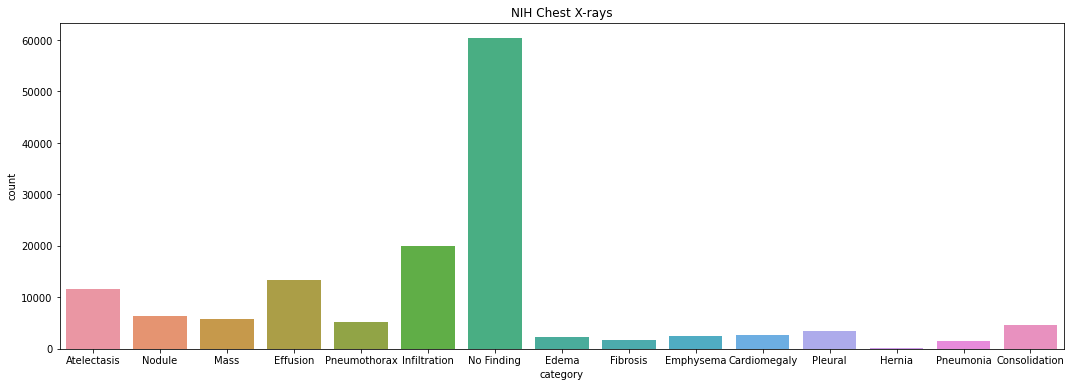

In [ ]:
all_labels = os.listdir('/content/Nih All d')

#see how many data from each category
data_path = '/content/Nih All d/'
count = []
for i in range(len(all_labels)):
    tmp_path = data_path + all_labels[i]
    tmp_count = len(os.listdir(tmp_path))
    count.append(tmp_count)

fig_dims = (18, 6)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('NIH Chest X-rays')
data_info = pd.DataFrame(count,all_labels)
data_info = data_info.reset_index()
data_info = data_info.rename(columns={"index": "category",0:"count"})
sns.barplot(x = 'category',y = 'count', ax=ax,data = data_info)

### 1.4) Select Part of Data
Since we have 141,537 images in our dataset, it will spend a lot of time to train model. So we could choose small part of data to do analysis.

We select X% of data from all dataset.


In [ ]:
#rm -rf '/content/Nih All d_Part_Data/'

a) Create PART_DATA file

In [ ]:
#Create part_data file
RAWDATA_PATH = '/content/Nih All d/'
PARTDATA_PATH = '/content/Nih All d_Part_Data/'

try:
    os.mkdir(PARTDATA_PATH)
except OSError:
        pass

b) Create Category Files


In [ ]:
train_path = PARTDATA_PATH + 'train/'
test_path =  PARTDATA_PATH + 'test/'

try:
    os.mkdir(train_path)
    os.mkdir(test_path)
except OSError:
        pass

for category in all_labels:
    #create new  category file
    try:
        os.mkdir(train_path + category)
        os.mkdir(test_path + category)
    except OSError:
        pass

c) Select X% of Rawdata from Raw data file to Part Data file

**MoveCateogryFolders** : This function aim to move images from source file to destination file.

In [ ]:
# Move image from different files and split it
def moveCategoryFolders(src, dst, spilt_pct):
    # move images between two folders
    def moveFolders(src, dst, spilt_pct):   
        global src_file
        src_file = os.listdir(src)
        num_images = len(src_file)
        if (num_images == 0):
            print("Source File: '" + src + "' is empty!") 
        else:
            move_num = int(num_images * spilt_pct)
            move_index = random.sample(range(0, num_images),move_num)
            for tmp_index in move_index:
                shutil.move(src + str(src_file[tmp_index]), dst + str(src_file[tmp_index]))
                
    for label in all_labels:
        src_path = src+ label+'/'
        dst_path = dst+ label+'/'
        moveFolders(src_path,dst_path,spilt_pct)

In [ ]:
#select 10% of rawdata to analyze
SELECT_PCT = 0.1
moveCategoryFolders(RAWDATA_PATH,PARTDATA_PATH + 'train/',SELECT_PCT)

d) Randomly select 15 images from Part_Data file as sample data
Use the Selected Image to do the following analysis

In [ ]:
import os, random, shutil
PARTDATA_PATH = '/content/Nih All d_Part_Data/'
ALLFILE_DIR = '/content/Nih All d_Part_Data/all_image/'

try:
    os.mkdir(ALLFILE_DIR)
except OSError:
        pass

for category in all_labels:
    FileNames = os.listdir(PARTDATA_PATH + 'train/'+ category)
    print(category + ": " +  str(len(FileNames)))

    for name in FileNames:
        shutil.copy(os.path.join(PARTDATA_PATH +'train/'+ category, name), os.path.join(ALLFILE_DIR, name))

all_file = os.listdir(ALLFILE_DIR)
sample = random.sample(all_file, 15)

print("***********************************")
print('Total images: ', len(all_file))
print('Select images: ', len(sample))
print(sample)

# for category in all_labels:
#     FileNames = os.listdir(SOURCE_DIR +category)
#     print(category + ": " +  str(len(FileNames)))
    
print("***********************************")        

Atelectasis: 1155
Nodule: 633
Mass: 578
Effusion: 1331
Pneumothorax: 530
Infiltration: 1989
No Finding: 6036
Edema: 230
Fibrosis: 168
Emphysema: 251
Cardiomegaly: 277
Pleural: 338
Hernia: 22
Pneumonia: 143
Consolidation: 466
***********************************
Total images:  13758
Select images:  15
['No Finding.00013975_000.png', 'Atelectasis.00000248_008.png', 'Atelectasis.Infiltration.00002856_013.png', 'No Finding.00013318_004.png', 'No Finding.00009508_007.png', 'Consolidation.Pleural_Thickening.00025395_000.png', 'Atelectasis.00003253_001.png', 'Atelectasis.Effusion.Infiltration.00005759_016.png', 'Consolidation.Infiltration.00018867_036.png', 'No Finding.00006451_003.png', 'No Finding.00021057_003.png', 'No Finding.00006150_005.png', 'No Finding.00011303_002.png', 'Atelectasis.Effusion.Infiltration.00013648_027.png', 'Cardiomegaly.00006912_007.png']
***********************************


### 1.5) Copy sample data to sample file and remove them from original file

In [ ]:
#rm -rf '/content/brain_tumor_dataset/'
SAMPLE_DIR = "/content/Nih All d_Part_Data/sample"
try:
    os.mkdir(SAMPLE_DIR)
except OSError:
        pass

for tmp_sample in sample:
    for category in all_labels:
        if(tmp_sample) in  os.listdir(os.path.join(PARTDATA_PATH + 'train/',category)):
            print("This sample image: " + tmp_sample +  " , original files is : " + category)
            shutil.move(os.path.join(PARTDATA_PATH + 'train/'+ category,tmp_sample),os.path.join(SAMPLE_DIR,tmp_sample))

print("*********After removing sample data****************")
for category in all_labels:
    dir = os.path.join(PARTDATA_PATH + 'train/',category)
    print("Current file" ,category,':',len(os.listdir(dir)))
print("***********************************")

This sample image: No Finding.00013975_000.png , original files is : No Finding
This sample image: Atelectasis.00000248_008.png , original files is : Atelectasis
This sample image: Atelectasis.Infiltration.00002856_013.png , original files is : Atelectasis
This sample image: No Finding.00013318_004.png , original files is : No Finding
This sample image: No Finding.00009508_007.png , original files is : No Finding
This sample image: Consolidation.Pleural_Thickening.00025395_000.png , original files is : Pleural
This sample image: Atelectasis.00003253_001.png , original files is : Atelectasis
This sample image: Atelectasis.Effusion.Infiltration.00005759_016.png , original files is : Effusion
This sample image: Consolidation.Infiltration.00018867_036.png , original files is : Infiltration
This sample image: No Finding.00006451_003.png , original files is : No Finding
This sample image: No Finding.00021057_003.png , original files is : No Finding
This sample image: No Finding.00006150_005.

### 1.6) Spilt training data and validation data

a) Split the images randomly into 90% training images and 10% test images

In [ ]:
SPLIT_SIZE = 0.1  
moveCategoryFolders(train_path,test_path,SPLIT_SIZE)

b) Check train data and test data

In [ ]:
num_train = 0
num_test = 0
for label in all_labels:
    train_file = os.listdir(train_path + label + '/')
    test_file = os.listdir(test_path + label + '/')
    num_train = num_train + len(train_file)
    num_test = num_test + len(test_file)

    
    print("-----------------------------")
    print('Category: ' + label)
    print('Train_num : '+ str(len(train_file)))
    print('Test_num : '+ str(len(test_file)))


print("*****************************")
print('Total images: ', num_train + num_test)
print('Training: ',  str(num_train))
print('Testing: ',  str(num_test))
print("*****************************")

-----------------------------
Category: Atelectasis
Train_num : 1037
Test_num : 115
-----------------------------
Category: Nodule
Train_num : 570
Test_num : 63
-----------------------------
Category: Mass
Train_num : 521
Test_num : 57
-----------------------------
Category: Effusion
Train_num : 1197
Test_num : 133
-----------------------------
Category: Pneumothorax
Train_num : 477
Test_num : 53
-----------------------------
Category: Infiltration
Train_num : 1789
Test_num : 198
-----------------------------
Category: No Finding
Train_num : 5427
Test_num : 602
-----------------------------
Category: Edema
Train_num : 207
Test_num : 23
-----------------------------
Category: Fibrosis
Train_num : 152
Test_num : 16
-----------------------------
Category: Emphysema
Train_num : 226
Test_num : 25
-----------------------------
Category: Cardiomegaly
Train_num : 249
Test_num : 27
-----------------------------
Category: Pleural
Train_num : 304
Test_num : 33
-----------------------------
Catego

###1.7) Plot sample images with labels

Let's try loading some images from the test dataset and displaying their class labels.

In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
        test_path,
        seed = 123,
        image_size = (224,224))

class_names = test_data.class_names

Found 1407 files belonging to 15 classes.


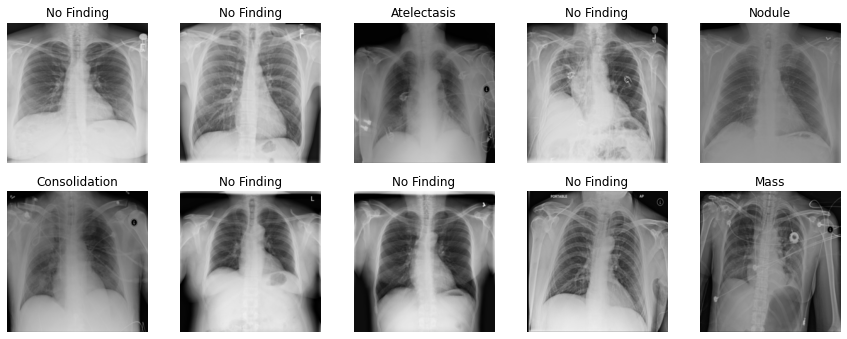

In [ ]:
plt.figure(figsize = (15,15))
for images,labels in test_data.take(1):
    for i in range(10):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Part 2: Data Augmentation

###2.1) Data Augmentation-Sample

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,
      width_shift_range=0.05,
      height_shift_range=0.05,
      shear_range=0.1,
      zoom_range=0.1,
      brightness_range=[0.3, 1.5],
      fill_mode='nearest') 

In [ ]:
SAMPLE_AUG_PATH = "/content/Data_Aug_Sample/"
try:
    os.mkdir(SAMPLE_AUG_PATH)
except OSError:
        pass

#Select any image and create 10 augumented images and save to file.
sample = cv2.imread('/content/Nih All d/Atelectasis/Atelectasis.00000011_006.png')
sample = sample.reshape((1,) + sample.shape)

i = 1
for batch in train_datagen.flow(sample, batch_size=1,save_to_dir =SAMPLE_AUG_PATH,save_prefix = 'aug_image',save_format = 'jpg' ):
    i += 1
    if i > 10:
        break

### 2.2) Show the sample data and augmented images

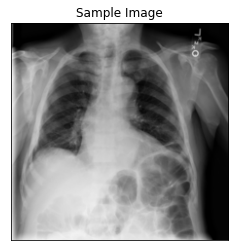

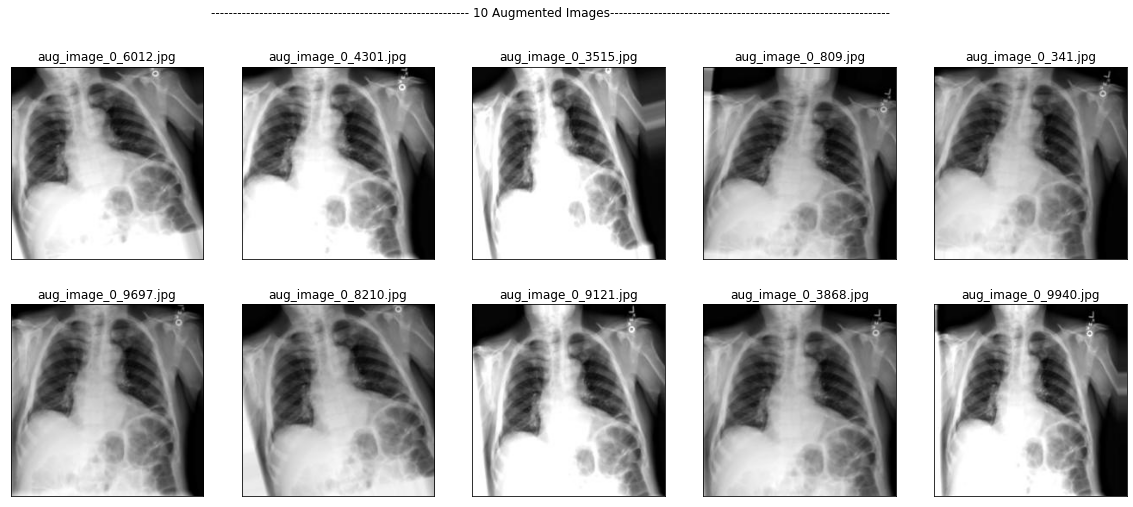

In [ ]:
sample_image = cv2.imread('/content/Nih All d/Atelectasis/Atelectasis.00000011_006.png')
plt.imshow(sample_image)
plt.xticks([])
plt.yticks([])
plt.title("Sample Image")
plt.show()

plt.figure(figsize = (20,8))
plt.suptitle("----------------------------------------------------------- 10 Augmented Images----------------------------------------------------------------")
i = 0
for image in os.listdir(SAMPLE_AUG_PATH):
    while(i<10):
        img = cv2.imread(SAMPLE_AUG_PATH +'/'+ image)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.subplot(2,5,i+1)
        plt.imshow(img)
        plt.title(image)
        plt.xticks([])
        plt.yticks([])
        break
    i +=1
plt.show()


### 2.3) Data Augmentation

In [ ]:
img_height = 224
img_width = 224
batch_size = 512

train_dir = '/content/Nih All d_Part_Data/train'
test_dir = '/content/Nih All d_Part_Data/test'

#Train data generator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,
      width_shift_range=0.05,
      height_shift_range=0.05,
      shear_range=0.1,
      zoom_range=0.1,
      fill_mode='nearest') 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    class_mode='categorical', 
    target_size=(img_height, img_width))

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_width))

Found 12725 images belonging to 15 classes.
Found 1407 images belonging to 15 classes.


In [ ]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(512, 224, 224, 3)
(512, 15)


##Part 3: Build Model
**Input Layer**:This represents our input image data. It will reshape the image into a single dimensional array.

**Conv Layer**: This layer will extract features from image.

**Pooling Layer**:This layer will reduce the spatial volume of input image after convolution.

**Fully Connected Layer**:This will connect the network from a layer to another layer.

**Output Layer**: This is the predicted values layer.

###3.1) Model without hyperparameter tunning

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
with tf.device('/GPU:0'):
    model = keras.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_width,img_height,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))

    model.add(Dense(15, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer = 'adam',
        metrics=['accuracy']
    )

    model.summary()

    history = model.fit(
      train_generator,
      epochs=20,
      validation_data=validation_generator,
      batch_size = 512
      )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
dropout_7 (Dropout)          (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 186624)           

In [ ]:
def plot_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

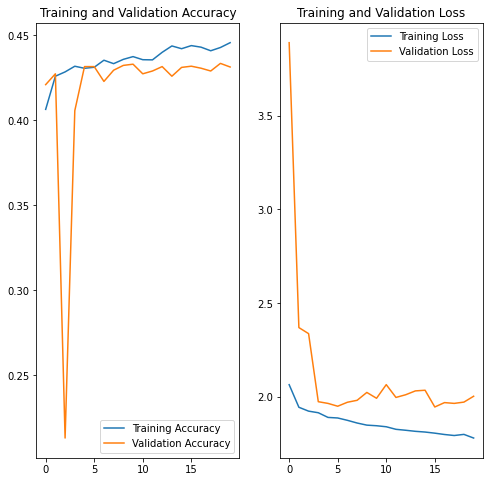

In [ ]:
plot_accuracy(history)

###3.2) Model with hyperparameter tunning

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 71kB 4.4MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=d8d9ef5808a78f7c25c8c3d2bc847ff9874910c0dcfd6063297357a356caeb0e
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=6bf6b985e80cbe1c5df4513c921963e4ebf5deb92885b300566a98984625d8e9
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from kerastuner import HyperModel

We use VGG16 as base model

In [ ]:
from keras.applications import VGG16
VGG_model = VGG16(weights = 'imagenet',
                   include_top = False,
                   input_shape = (224,224,3))

Build hyper model

In [ ]:
class HyperModel(HyperModel):
    def __init__(self,input_shape,num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self,hp):
        model_hyper = keras.Sequential()
        model_hyper.add(VGG_model)
        # model_hyper.add(Conv2D(
        #    filters=hp.Choice(
        #         'num_filters',
        #         values=[32,64,128,256],
        #         default=64,
        #     ),
        #     padding = 'same',
        #     activation='relu',
        #     kernel_size=3))

        # model_hyper.add(MaxPooling2D(2,2))
        # model_hyper.add(BatchNormalization())
        # model_hyper.add(Conv2D(
        #    filters=hp.Choice(
        #         'num_filters',
        #         values=[32,64,128,256],
        #         default=64,
        #     ),
        #     padding = 'same',
        #     activation='relu',
        #     kernel_size=3))

        model_hyper.add(layers.Flatten())
        model_hyper.add(
            Dropout(rate = hp.Float(
                'dropout',
                min_value = 0,
                max_value = 0.5,
                default = 0.25,
                step = 0.05
            ))
        )
        model_hyper.add(
                Dense(
                    units = hp.Int(
                        'units',
                        min_value = 64,
                        max_value = 512,
                        step = 32,
                        default = 256
                    ),
                    activation = hp.Choice(
                        'dense_activation',
                        values = ['relu','sigmoid'],
                        default = 'relu'
                    )
                )
            )

        model_hyper.add(Dense(64,activation = 'relu'))
        model_hyper.add(layers.Dense(15,activation = 'softmax'))

        model_hyper.compile(
            loss = 'categorical_crossentropy',
            optimizer = keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value = 1e-4,
                    max_value = 1e-2,
                    sampling = 'LOG',
                    default = 1e-3
                )
            ),
            metrics = ['accuracy']
        )
        return model_hyper

In [ ]:
from kerastuner.tuners import RandomSearch

NUM_CLASSES = 15
INPUT_SHAPE = (img_width,img_height,3)
HYPERBAND_MAX_EPOCHS = 5
MAX_TRIALS = 5
EXECUTION_PER_TRIAL = 2
SEED = 1

hyper_model = HyperModel(input_shape= INPUT_SHAPE, num_classes= NUM_CLASSES)

hyper_tunner = RandomSearch(
    hyper_model,
    objective = 'val_accuracy',
    seed = SEED,
    max_trials = MAX_TRIALS,
    executions_per_trial = EXECUTION_PER_TRIAL,
    directory = 'random_search',
    project_name = 'chest x-ray'
)

hyper_tunner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project random_search/chest x-ray/oracle.json
Search space summary
Default search space size: 4
dropout (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units (Int)
{'default': 256, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
with tf.device('/GPU:0'):
    hyper_tunner.search(train_generator,
                    validation_data = validation_generator, 
                    epochs = 10)

Trial 5 Complete [00h 52m 21s]
val_accuracy: 0.4267827868461609

Best val_accuracy So Far: 0.45617854595184326
Total elapsed time: 04h 24m 01s
INFO:tensorflow:Oracle triggered exit


Find out the best model

In [ ]:
hyper_tunner.results_summary()
best_model = hyper_tunner.get_best_models(num_models = 1)[0]

Results summary
Results in random_search/chest x-ray
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
units: 416
dense_activation: sigmoid
learning_rate: 0.00028406107009737317
Score: 0.45617854595184326
Trial summary
Hyperparameters:
dropout: 0.1
units: 480
dense_activation: relu
learning_rate: 0.0002965488058019691
Score: 0.4507348984479904
Trial summary
Hyperparameters:
dropout: 0.2
units: 320
dense_activation: sigmoid
learning_rate: 0.0008894905887153519
Score: 0.4477408826351166
Trial summary
Hyperparameters:
dropout: 0.1
units: 96
dense_activation: relu
learning_rate: 0.0005285006792644589
Score: 0.4368535578250885
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
units: 160
dense_activation: relu
learning_rate: 0.006475590128522282
Score: 0.4267827868461609


In [ ]:
history_best_model = best_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30)

Epoch 1/30
97/97 [==============================] - 158s 2s/step - loss: 1.6877 - accuracy: 0.4678 - val_loss: 1.7988 - val_accuracy: 0.4437
Epoch 2/30
97/97 [==============================] - 158s 2s/step - loss: 1.6275 - accuracy: 0.4886 - val_loss: 1.8658 - val_accuracy: 0.4437
Epoch 3/30
97/97 [==============================] - 158s 2s/step - loss: 1.6248 - accuracy: 0.4887 - val_loss: 1.8186 - val_accuracy: 0.4431
Epoch 4/30
97/97 [==============================] - 157s 2s/step - loss: 1.5949 - accuracy: 0.4983 - val_loss: 1.8046 - val_accuracy: 0.4524
Epoch 5/30
97/97 [==============================] - 157s 2s/step - loss: 1.5853 - accuracy: 0.5017 - val_loss: 1.8107 - val_accuracy: 0.4437
Epoch 6/30
97/97 [==============================] - 156s 2s/step - loss: 1.5656 - accuracy: 0.4989 - val_loss: 1.8319 - val_accuracy: 0.4409
Epoch 7/30
97/97 [==============================] - 157s 2s/step - loss: 1.5198 - accuracy: 0.5184 - val_loss: 1.8562 - val_accuracy: 0.4355
Epoch 8/30
97

Plot the accuracy

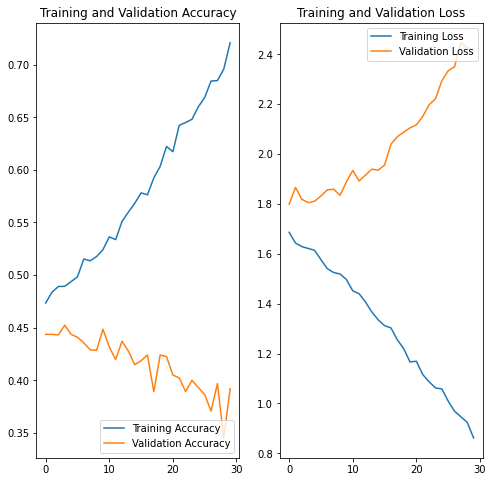

In [ ]:
plot_accuracy(history_best_model)

By using hyperparameter tunning, we can notice that the model is not good.And it has some problem of overfitting.

Predict using Test Data

In [ ]:
# Predict using Test Data

for file in os.listdir(os.path.join(SAMPLE_DIR)):
    print("Sample Image: ",file)
    img = keras.preprocessing.image.load_img(
    os.path.join(os.path.join(SAMPLE_DIR, file)), 
                target_size=(img_height, img_width))

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = best_model.predict(img_array)
    score = tf.nn.sigmoid(predictions[0])
    
    print("The predicaiton result : " ,predictions[0][0])
    print( score)
    print()

Sample Image:  No Finding.00021865_002.png
The predicaiton result :  0.05548402
tf.Tensor(
[0.51386744 0.5025984  0.5081701  0.50330204 0.5182478  0.50421447
 0.50380486 0.5003579  0.52895886 0.50864697 0.62248796 0.5126591
 0.5066887  0.50184083 0.5115608 ], shape=(15,), dtype=float32)

Sample Image:  Atelectasis.Effusion.00016522_025.png
The predicaiton result :  0.07226557
tf.Tensor(
[0.51805854 0.5047009  0.5101328  0.50378877 0.5234843  0.5045675
 0.5036698  0.5003843  0.5277619  0.5099612  0.61239576 0.51183075
 0.5061394  0.5019597  0.50915146], shape=(15,), dtype=float32)

Sample Image:  No Finding.00019001_004.png
The predicaiton result :  0.07311854
tf.Tensor(
[0.5182715  0.5050201  0.50935423 0.5039049  0.52207243 0.5043519
 0.50402695 0.50038105 0.5272204  0.5099709  0.6106111  0.5136903
 0.50607723 0.50206894 0.51106083], shape=(15,), dtype=float32)

Sample Image:  No Finding.00015449_001.png
The predicaiton result :  0.07771772
tf.Tensor(
[0.51941967 0.50510377 0.5107116 

## PART 4 : K-FOLD Crocss Validation

In [ ]:
SOURCE_PATH = '/content/Nih All d_Part_Data/'

### 4.1) Store file names in X variables; store class labels in Y variables

In [ ]:
X=[]
Y=[]

for i in range(len(all_labels)):
    folder_name = all_labels[i]
    src_files = os.listdir(PARTDATA_PATH + '/train/' + folder_name)
    for tmp_file in src_files:
        X.append(tmp_file)
        for i in range(len(all_labels)):
            if(folder_name == all_labels[i]):
                Y.append(i)
            else: 
                continue

X = np.asarray(X)
Y = np.asarray(Y)

Build Model

In [ ]:
batch_size = 128
epoch = 10
img_height = 224
img_width = 224

def getModel():
    model = tf.keras.models.Sequential()

    #model.add(VGG_model)
    model.add(Conv2D(64, (3, 3), 
                     padding='same',
                     activation='relu',
                     input_shape=(img_height, img_width, 3)))
    
  # model.add(Conv2D(64, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(32,
                     (3, 3),
                     padding='same', 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(15, activation='softmax')) 

    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

**show_metrics** This function is used to print accuracy, precision , and f1Score. And it can plot confusion matrix.

In [ ]:
  def show_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred,average='weighted')
    score = f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(acc))
    print("Precision : {}".format(prec))
    print("f1Score : {}".format(score))
    
    fig,ax = plt.subplots(figsize = (10,10))
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix = conf_matrix/np.sum(conf_matrix)
    
    sns.heatmap(conf_matrix,annot = True,fmt = '.2f',square = True,cbar = False,cmap = plt.cm.jet,ax = ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show(block = False)
    #print(conf_matrix)

    return acc, prec, score

Train model with K-Flod CV

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 100352)          

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
97/97 [==============================] - 130s 1s/step - loss: 2.7538 - accuracy: 0.3252 - val_loss: 2.1205 - val_accuracy: 0.4266
Epoch 2/10
97/97 [==============================] - 128s 1s/step - loss: 2.0491 - accuracy: 0.4253 - val_loss: 1.9953 - val_accuracy: 0.4266
Epoch 3/10
97/97 [==============================] - 128s 1s/step - loss: 2.0046 - accuracy: 0.4196 - val_loss: 1.9911 - val_accuracy: 0.4276
Epoch 4/10
97/97 [==============================] - 128s 1s/step - loss: 1.9894 - accuracy: 0.4206 - val_loss: 1.9939 - val_accuracy: 0.4266
Epoch 5/10
97/97 [==============================] - 129s 1s/step - loss: 1.9760 - accuracy: 0.4206 - val_loss: 1.9501 - val_accuracy: 0.4266
Epoch 6/10
97/97 [==============================] - 128s 1s/step - loss: 1.9568 - accuracy: 0.4320 - val_loss: 1.9488 - val_accuracy: 0.4266
Epoch 7/10
97/97 [==============================] - 128s 1s/step - loss: 1.9682 - accuracy: 0.4240 - val_loss: 1.9905 - val_accuracy: 0.4266
Epoch 8/10
97

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


15/15 [==============================] - 3s 207ms/step
---Performance Result----
Accuracy  : 0.426550598476605
Precision : 0.1819454130607499
f1Score : 0.25508441587006736


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


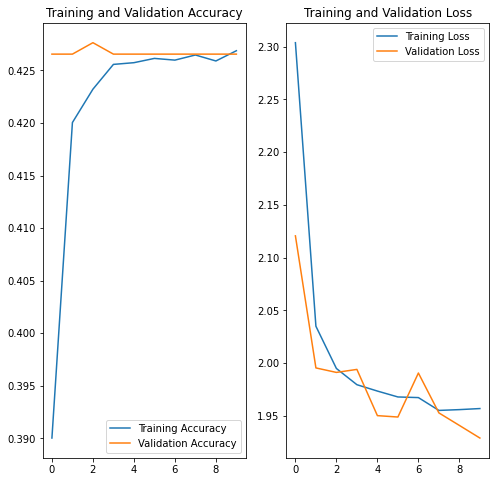

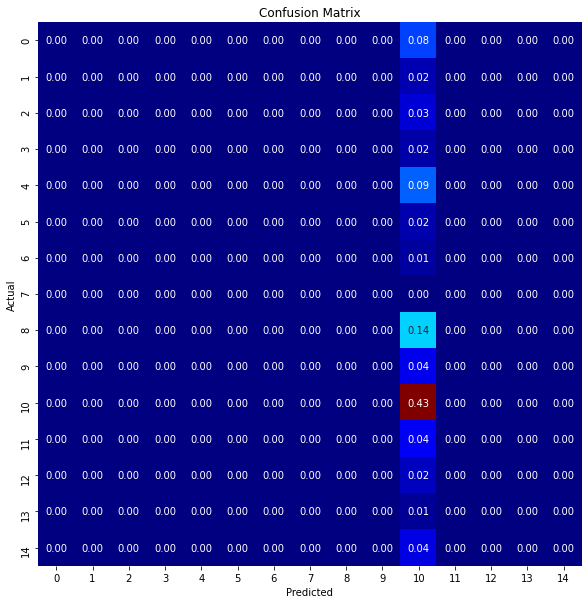


Results for Fold:  2
Found 12294 images belonging to 15 classes.
Found 1838 images belonging to 15 classes.
Epoch 1/10
97/97 [==============================] - 128s 1s/step - loss: 1.9484 - accuracy: 0.4267 - val_loss: 1.9332 - val_accuracy: 0.4260
Epoch 2/10
97/97 [==============================] - 127s 1s/step - loss: 1.9467 - accuracy: 0.4270 - val_loss: 1.9480 - val_accuracy: 0.4266
Epoch 3/10
97/97 [==============================] - 127s 1s/step - loss: 1.9467 - accuracy: 0.4257 - val_loss: 1.9407 - val_accuracy: 0.4260
Epoch 4/10
97/97 [==============================] - 127s 1s/step - loss: 1.9374 - accuracy: 0.4291 - val_loss: 1.9692 - val_accuracy: 0.4260
Epoch 5/10
97/97 [==============================] - 127s 1s/step - loss: 1.9378 - accuracy: 0.4276 - val_loss: 1.9229 - val_accuracy: 0.4266
Epoch 6/10
97/97 [==============================] - 128s 1s/step - loss: 1.9340 - accuracy: 0.4270 - val_loss: 1.9239 - val_accuracy: 0.4282
Epoch 7/10
97/97 [===========================

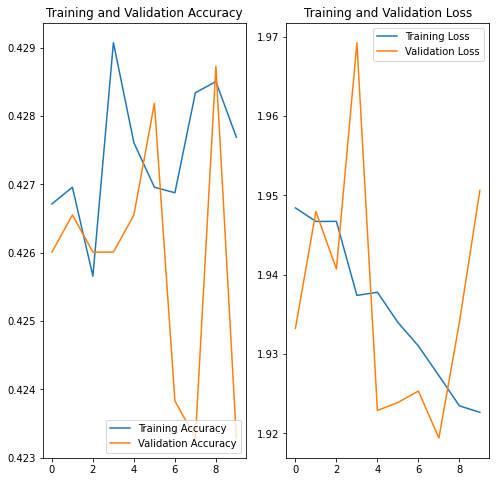

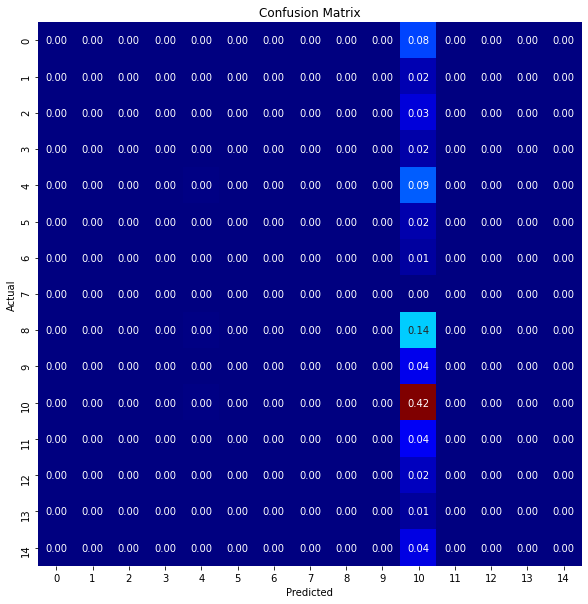


Results for Fold:  3
Found 12295 images belonging to 15 classes.
Found 1837 images belonging to 15 classes.
Epoch 1/10
97/97 [==============================] - 128s 1s/step - loss: 1.9225 - accuracy: 0.4281 - val_loss: 1.8999 - val_accuracy: 0.4311
Epoch 2/10
97/97 [==============================] - 128s 1s/step - loss: 1.9185 - accuracy: 0.4261 - val_loss: 1.9391 - val_accuracy: 0.4284
Epoch 3/10
97/97 [==============================] - 128s 1s/step - loss: 1.9184 - accuracy: 0.4288 - val_loss: 1.9063 - val_accuracy: 0.4333
Epoch 4/10
97/97 [==============================] - 129s 1s/step - loss: 1.9131 - accuracy: 0.4288 - val_loss: 1.8987 - val_accuracy: 0.4311
Epoch 5/10
97/97 [==============================] - 129s 1s/step - loss: 1.9166 - accuracy: 0.4296 - val_loss: 1.9123 - val_accuracy: 0.4306
Epoch 6/10
97/97 [==============================] - 130s 1s/step - loss: 1.9118 - accuracy: 0.4291 - val_loss: 1.9570 - val_accuracy: 0.4306
Epoch 7/10
97/97 [===========================

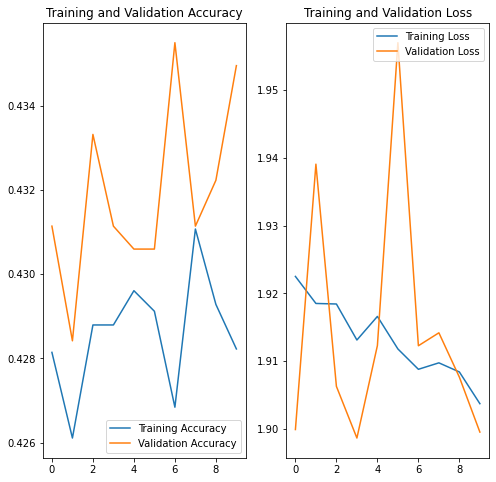

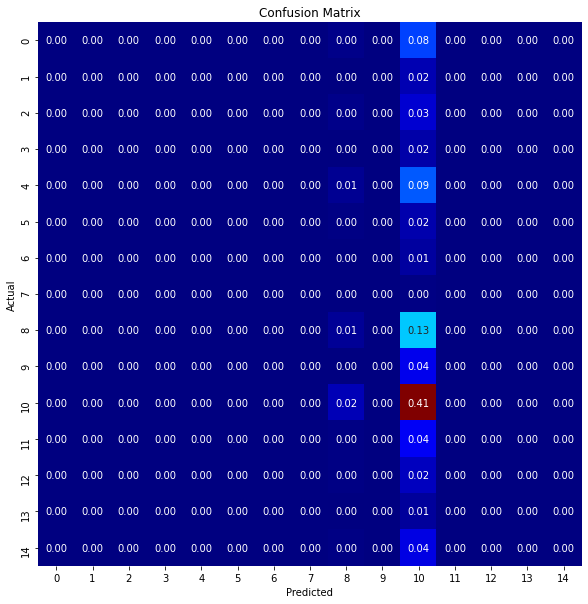


Results for Fold:  4
Found 12295 images belonging to 15 classes.
Found 1837 images belonging to 15 classes.
Epoch 1/10
97/97 [==============================] - 129s 1s/step - loss: 1.9065 - accuracy: 0.4305 - val_loss: 1.8798 - val_accuracy: 0.4355
Epoch 2/10
97/97 [==============================] - 129s 1s/step - loss: 1.9049 - accuracy: 0.4307 - val_loss: 1.8891 - val_accuracy: 0.4306
Epoch 3/10
97/97 [==============================] - 128s 1s/step - loss: 1.9030 - accuracy: 0.4270 - val_loss: 1.8881 - val_accuracy: 0.4344
Epoch 4/10
97/97 [==============================] - 128s 1s/step - loss: 1.9013 - accuracy: 0.4288 - val_loss: 1.8841 - val_accuracy: 0.4355
Epoch 5/10
97/97 [==============================] - 129s 1s/step - loss: 1.9027 - accuracy: 0.4310 - val_loss: 1.8777 - val_accuracy: 0.4322
Epoch 6/10
97/97 [==============================] - 129s 1s/step - loss: 1.8986 - accuracy: 0.4294 - val_loss: 1.8873 - val_accuracy: 0.4295
Epoch 7/10
97/97 [===========================

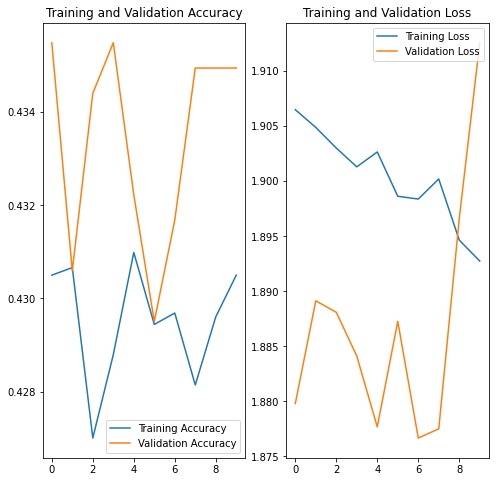

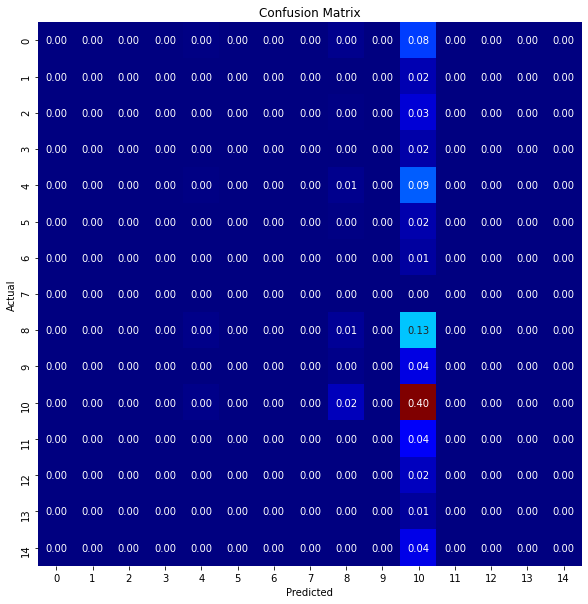


Results for Fold:  5
Found 12295 images belonging to 15 classes.
Found 1837 images belonging to 15 classes.
Epoch 1/10
97/97 [==============================] - 129s 1s/step - loss: 1.8910 - accuracy: 0.4333 - val_loss: 1.8862 - val_accuracy: 0.4284
Epoch 2/10
97/97 [==============================] - 129s 1s/step - loss: 1.8882 - accuracy: 0.4326 - val_loss: 1.9017 - val_accuracy: 0.4295
Epoch 3/10
97/97 [==============================] - 128s 1s/step - loss: 1.8873 - accuracy: 0.4344 - val_loss: 1.8977 - val_accuracy: 0.4317
Epoch 4/10
97/97 [==============================] - 128s 1s/step - loss: 1.8865 - accuracy: 0.4346 - val_loss: 1.8966 - val_accuracy: 0.4317
Epoch 5/10
97/97 [==============================] - 128s 1s/step - loss: 1.8826 - accuracy: 0.4341 - val_loss: 1.8938 - val_accuracy: 0.4317
Epoch 6/10
97/97 [==============================] - 128s 1s/step - loss: 1.8858 - accuracy: 0.4327 - val_loss: 1.8866 - val_accuracy: 0.4333
Epoch 7/10
97/97 [===========================

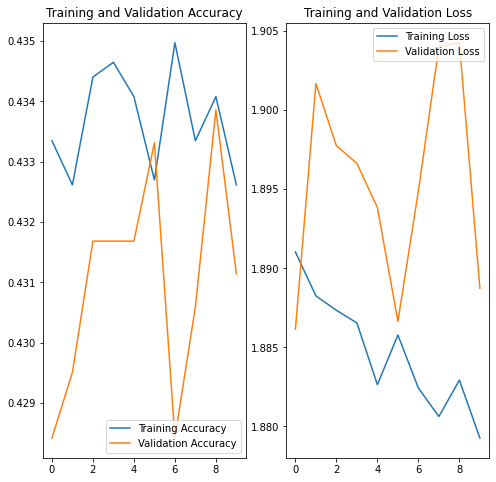

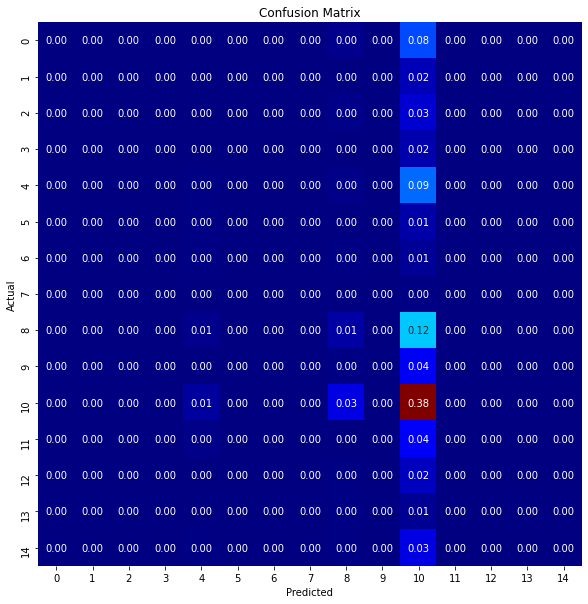

In [ ]:
from sklearn.model_selection import StratifiedKFold

with tf.device('/GPU:0'):
    model = getModel()

    n_splits = 5
    skf = StratifiedKFold(n_splits = n_splits, shuffle=True)
    skf.get_n_splits(X, Y)

    fold_num = 0

    for train_index, val_index in skf.split(X, Y):
        fold_num += 1
        moveCategoryFolders(test_path, train_path, 1.0)
        print("Results for Fold: ", fold_num )
        
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        # Move validation images of this fold from train folder to the validation folder
        for eachIndex in range(len(X_val)):
            classLabel=''
            classLabel = all_labels[Y_val[eachIndex]]
        
            #Then, copy the validation images to the validation folder
            shutil.move(PARTDATA_PATH + 'train/' + classLabel +'/'+ X_val[eachIndex], 
                        PARTDATA_PATH + 'test/'+ classLabel +'/'+ X_val[eachIndex])

        #-----------
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.1,
            zoom_range=0.1,
            fill_mode='nearest') 

        train_generator = train_datagen.flow_from_directory(
            train_path,
            batch_size=batch_size,
            class_mode='categorical', 
            target_size=(img_height, img_width))

        test_datagen = ImageDataGenerator( rescale = 1.0/255. )

        validation_generator = test_datagen.flow_from_directory(
            test_path,
            batch_size=batch_size,
            class_mode='categorical',
            target_size=(img_height, img_width))
        
        #---------
        # fit model
        history = model.fit_generator(train_generator, 
                                    validation_data = validation_generator,
                                    epochs=epoch)
        
        print(history.history.keys())
        plot_accuracy(history)

        pred = model.predict_generator(validation_generator, verbose=1)
        y_pred= np.argmax(pred, axis=1)
        val_class = validation_generator.classes

        print("---Performance Result----")    
        show_metrics(val_class, y_pred)
        print()

## Reference：



1.   https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
2.   https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
